[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

## Learning Channel Distribution by Diffusion Models
 
This notebook file is a framework to learn channels by their conditional distributions: the distirubtions of the channel output for given channel inputs. To serve that, we edited a standard 1-dimensional U-Net to be conditional on the channel input. For the channel model, we used a correlated Rayleigh fading model.

In [2]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import torch
#import tqdm as notebook_tqdm
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import importlib
import sys
sys.path.append('src/')

# Import modules from own libraries
from denoising_diffusion_pytorch_1d_cond import GaussianDiffusion1D, Unet1D, Trainer1D, Dataset1D
import channel_models
import WGAN

# Set the writer
writer_G = SummaryWriter("runs/wgan_G_cnn_trspsdG")
writer_D = SummaryWriter("runs/wgan_D_cnn_trspsdG")

# Set the device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Set the path for saving and loading models
path = 'state_dict_convtransposedG'

2024-05-21 13:23:36.020040: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 13:23:36.022138: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 13:23:36.049879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 13:23:36.589498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Choose channel model and diffusion model type

In [3]:
channel_model_str = 'corrRayleigh' #available options: AWGN, Rayleigh, SSPA

## Channel model settings

In [4]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

class Channel_Config:
    def __init__(self, channel_model_str, blocklength, training_noise_std, device="cpu", f_dopp_norm=None):
        super().__init__()
        self.channel_model_str = channel_model_str
        self.blocklength = blocklength
        self.training_noise_std = training_noise_std
        self.device = device
        self.f_dopp_norm = f_dopp_norm
        self.cov = channel_models.Rayleigh_covariance_generator(n, f_dopp_norm,
                                                 dtype_cov=torch.cfloat) if f_dopp_norm is not None else None

    def channel_model_fn(self):
        channel_model_str = self.channel_model_str
        if channel_model_str == 'AWGN':
            channel_model = channel_models.ch_AWGN
        elif channel_model_str == 'Rayleigh':
            channel_model = channel_models.ch_Rayleigh_AWGN_n
        elif channel_model_str == 'SSPA':
            channel_model = channel_models.ch_SSPA
        elif channel_model_str == 'corrRayleigh':
            assert f_dopp_norm is not None, 'The normalized doppler frequency, f_dopp_norm, is not given.'
            cov = self.cov
            channel_model = partial(channel_models.ch_corr_Rayleigh_by_cov, Cov_h=cov)
        else:
            raise Exception("Unrecognized channel model. Possible channel models: AWGN, Rayleigh, SSPA.")
        self.channel_model = channel_model
        return channel_model

    def show_cov(self):
        fig, ax = plt.subplots(figsize=(3, 3))
        im = ax.imshow(self.cov.real, cmap='hot', )  # , interpolation='nearest')
        ax.set_title(r'Covariance, $\bar{f}_D=' + str(self.f_dopp_norm) + '$')
        plt.colorbar(im, ax=ax, fraction=0.046)
        plt.savefig(f'figures/cov_fD={self.f_dopp_norm:.3f}.pdf')
        plt.show()


In [5]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [6]:
def generate_training_seq(dataset_size, Config_ch, batch_size = 100):
    n = Config_ch.blocklength
    training_seq = torch.zeros(dataset_size, 2*2, n)
    idx = 0
    for i, batch in enumerate(torch.split(training_seq, batch_size)):
        bs = batch.shape[0]
        
        training_x = torch.randn(bs, n, dtype=torch.cfloat)
        channel_model = Config_ch.channel_model_fn()
        training_y = channel_model(training_x, Config_ch.training_noise_std, Config_ch.device)
        training_x = torch.transpose(torch.view_as_real(training_x), 1, 2)
        training_y = torch.transpose(torch.view_as_real(training_y), 1, 2)
        training_seq[idx:idx+bs, :, :] = torch.cat((training_y, training_x), dim=1)
        idx += bs
    return training_seq

In [25]:
def compare_empirical_cov(model_G, Config_ch, num_samples = 10 **3, bs=100, milestone=0):
    # y = Hx = h, when H = diag(h) and x = (1,1,1,...,1,1)^T. 
    ## For such channel input, generative network can generate the channel state information h.
    device = Config_ch.device
    ## Sample the channel coefficients by using the identity channel input. 
    condition_ones = torch.ones([bs, n], dtype=torch.cfloat, device=device)
    condition_ones = torch.transpose(torch.view_as_real(condition_ones), 1,2).contiguous()
    
    generated_h = torch.zeros([num_samples, 2, n])
    for it in range(num_samples//bs):
        generated_h[it*bs:(it+1)*bs,:, :] = model_G(condition_ones).detach().cpu()
    generated_h_t = torch.transpose(generated_h, 1,2)
    generated_h_t = generated_h_t.contiguous() # After taking transpose, it's necessary. 
    h_gen = torch.view_as_complex(generated_h_t)
    
    cov_emp = torch.cov(h_gen.T).numpy()
    idx = np.arange(n)    
    cov_emp[idx, idx] -= 2*noise_std ** 2
    
    fig_cov_comparison, [ax1, ax2] = plt.subplots(1,2)
    im1 = ax1.imshow(Config_ch.cov.real, cmap='hot') # , interpolation='nearest')
    ax1.set_title('defined cov.')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    im2 = ax2.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
    ax2.set_title('emp. cov.')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    fig_cov_comparison.suptitle(
        r'$\bar{f}_{D}$'+f'={Config_ch.f_dopp_norm}, # of Samples={num_samples}', y=0.9)
    fig_cov_comparison.tight_layout()
    plt.savefig(f'figures/emp_cov_WGAN_convtransposedG_fD_{f_dopp_norm:.3f}_ns{num_samples}_ms{milestone}.pdf')
    plt.show()
    return h_gen

In [ ]:
def plot_emp_cov(model_G, Config_ch, num_samples = 10 **3, milestone=0):
    # y = Hx = h, when H = diag(h) and x = (1,1,1,...,1,1)^T. 
    ## For such channel input, generative network can generate the channel state information h.
    device = Config_ch.device
    ## Sample the channel coefficients by using the identity channel input. 
    condition_ones = torch.ones([num_samples, n], dtype=torch.cfloat, device=device)
    condition_ones = torch.transpose(torch.view_as_real(condition_ones), 1,2).contiguous()
    generated_h = model_G(condition_ones)

    generated_h_t = torch.transpose(generated_h, 1,2)
    generated_h_t = generated_h_t.contiguous() # After taking transpose, it's necessary. 
    h_gen = torch.view_as_complex(generated_h_t)
    
    cov_emp = torch.cov(h_gen.T).detach().cpu().numpy()
    idx = np.arange(n)    
    cov_emp[idx, idx] -= 2*noise_std ** 2
    
    fig_cov = plt.figure(figsize=(3,3))
    im = plt.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    fig_cov.tight_layout()
    plt.savefig(f'figures/emp_cov_WGAN_convtransposedG_ms{milestone}.pdf', bbox_inches='tight')
    plt.show()
    return generated_h

In [7]:
# Channel Model
n = 128  # Block length
f_dopp_norm = 0.01
TRAINING_SNR = 15 # decibel
noise_std = SNR_to_noise(TRAINING_SNR)
Config_ch = Channel_Config(channel_model_str, n, noise_std, device=device, f_dopp_norm=f_dopp_norm)

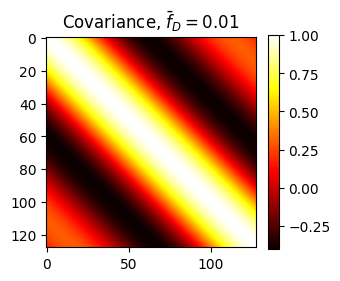

In [8]:
Config_ch.show_cov()

In [9]:
channel_fn = Config_ch.channel_model_fn()

In [10]:
channel_model = partial(channel_fn, AWGN_std=noise_std, device =device)

In [11]:
def _sort_rows(matrix, num_rows):
  """Sort matrix rows by the last column.

  Args:
      matrix: a matrix of values (row,col).
      num_rows: (int) number of sorted rows to return from the matrix.

  Returns:
      Tensor (num_rows, col) of the sorted matrix top K rows.
  """
  tmatrix = torch.transpose(matrix, 1, 0) 
  sorted_matrix = torch.topk(tmatrix, k=num_rows)[0] #tf.nn.top_k(tmatrix, num_rows)[0]
  return torch.transpose(sorted_matrix, 1, 0) 

def _sliced_wasserstein(a, b, random_sampling_count, random_projection_dim=1):
  """Compute the approximate sliced Wasserstein distance.

  Args:
      a: (matrix) Distribution "a" of samples (row, col).
      b: (matrix) Distribution "b" of samples (row, col).
      random_sampling_count: (int) Number of random projections to average.
      random_projection_dim: (int) Dimension of the random projection space.

  Returns:
      Float containing the approximate distance between "a" and "b".
  """
  s = a.shape #tf.shape(input=a)
  means = []
  for _ in range(random_sampling_count):
    # Random projection matrix.
    proj = torch.randn(s[1], random_projection_dim) 
    proj *= (torch.sum(proj ** 2, dim=0)) ** (-0.5) # normalizing the projection 
    # Project both distributions and sort them.
    proj_a = torch.matmul(a, proj) 
    proj_b = torch.matmul(b, proj) 
    proj_a = _sort_rows(proj_a, s[0])
    proj_b = _sort_rows(proj_b, s[0])
    # Pairwise Wasserstein distance.
    wdist = torch.mean( torch.abs(proj_a - proj_b) ) 
    means.append(wdist.detach().cpu().numpy())
  return np.mean(means) 


## Deep Learning Settings - model parameters, training and testing hyperparameters, etc.

In [12]:
#GAN parameters 
G = WGAN.Generator_DCGAN_1D(n)
D = WGAN.Discriminator_CNN_1D(n, 24)

total_params_gen = sum(p.numel() for p in G.parameters() if p.requires_grad)
print('# of parameters (Generator): ' + str(total_params_gen))
total_params_gen = sum(p.numel() for p in D.parameters() if p.requires_grad)
print('# of parameters (Discriminator): ' + str(total_params_gen))

G = G.to(device)
D = D.to(device)

d_lr = 1e-4
g_lr = 1e-4


# of parameters (Generator): 2822018
# of parameters (Discriminator): 455232


In [ ]:
writer_G.add_graph(G, torch.randn(1,2,n, device=device))
writer_D.add_graph(D, (torch.randn(1,2,n, device=device), torch.randn(1,2,n, device=device)))

In [16]:
num_epochs = 1000
milestone = 50
save_every = 100
d_lr = 1e-4
g_lr = 1e-4

LOAD = True

step = 0
if LOAD:
    G.load_state_dict(torch.load(f'{path}/G-{milestone}.pt', map_location=device))
    D.load_state_dict(torch.load(f'{path}/D-{milestone}.pt', map_location=device))
    step = milestone * save_every 



Epoch 999:  


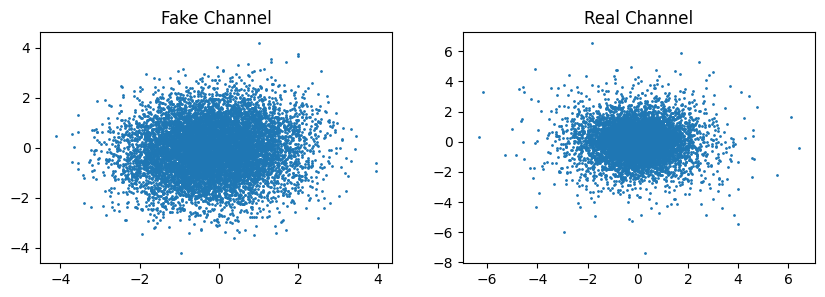

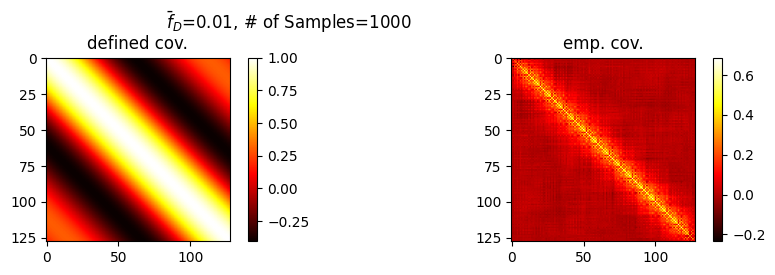

Epoch 1000: KL Div 2.966e-02 G loss 3.079e-01 D loss 9.955e-03: 100


In [35]:

with tqdm(initial = step, total=num_epochs, ascii=True) as pbar:  
    while step < num_epochs:
        g_loss, d_loss, kl_loss = WGAN.train_WGAN_CNN(G, D, batch_size, n, channel_model, d_lr, g_lr, is_GP=False)
        
        writer_G.add_scalar('train_loss/g_loss', g_loss, step)
        writer_G.add_scalar('train_loss/kl_loss', kl_loss, step)
        writer_D.add_scalar('train_loss/d_loss', d_loss, step)
        
        pbar.set_description(f"Epoch {step+1}: KL Div {kl_loss:.3e} G loss {-g_loss:.3e} D loss {-d_loss:.3e}")

        if (step+1) % 1000 == 0:
            WGAN.plot_GAN(G, 10000, n, channel_model, step)
        if (step+1) % save_every == 0:
            milestone = (step+1) // save_every 
            torch.save(G.state_dict(), f'{path}/G-{milestone}.pt')
            torch.save(D.state_dict(), f'{path}/D-{milestone}.pt')
    
            _ = compare_empirical_cov(G, Config_ch, num_samples = 10 **3, milestone=milestone)
       
        step += 1
        pbar.update(1)
        

Epoch 2999:  


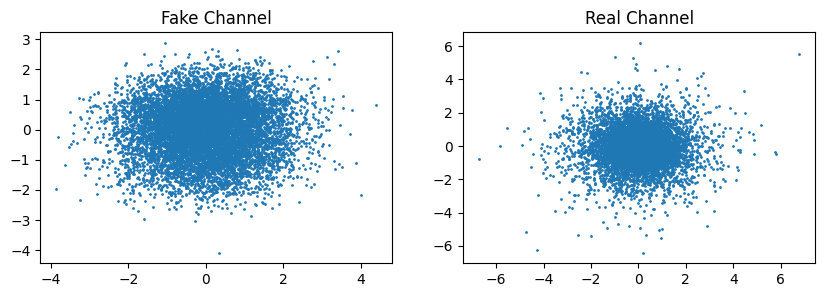

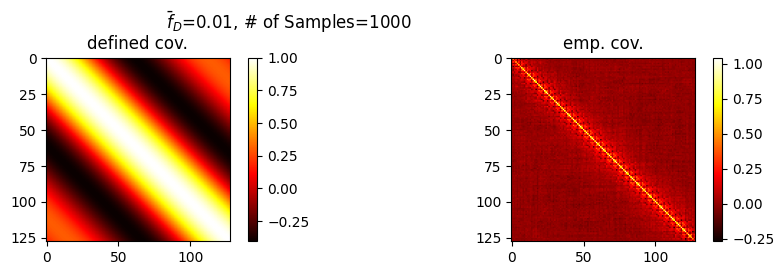

Epoch 3000: KL Div 3.247e-02 G loss 1.187e-02 D loss 1.159e-02: 100


In [17]:
num_epochs = 3000
save_every = 100
batch_size = 100
d_lr = 5e-5
g_lr = 5e-5

LOAD = True
milestone = 10
if LOAD:
    G.load_state_dict(torch.load(f'{path}/G-{milestone}.pt', map_location=device))
    D.load_state_dict(torch.load(f'{path}/D-{milestone}.pt', map_location=device))
    step = milestone * save_every 

with tqdm(initial = step, total=num_epochs, ascii=True) as pbar:  
    while step < num_epochs:
        g_loss, d_loss, kl_loss = WGAN.train_WGAN_CNN(G, D, batch_size, n, channel_model, d_lr, g_lr, is_GP=False)
        
        writer_G.add_scalar('train_loss/g_loss', g_loss, step)
        writer_G.add_scalar('train_loss/kl_loss', kl_loss, step)
        writer_D.add_scalar('train_loss/d_loss', d_loss, step)
        
        pbar.set_description(f"Epoch {step+1}: KL Div {kl_loss:.3e} G loss {-g_loss:.3e} D loss {-d_loss:.3e}")

        if (step+1) % 1000 == 0:
            WGAN.plot_GAN(G, 10000, n, channel_model, step)
        if (step+1) % save_every == 0:
            milestone = (step+1) // save_every 
            torch.save(G.state_dict(), f'{path}/G-{milestone}.pt')
            torch.save(D.state_dict(), f'{path}/D-{milestone}.pt')
    
            _ = compare_empirical_cov(G, Config_ch, num_samples = 10 **3, milestone=milestone)
       
        step += 1
        pbar.update(1)
        

Epoch 3999:  


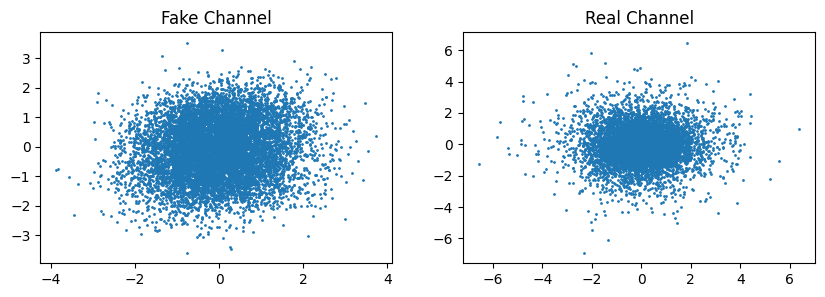

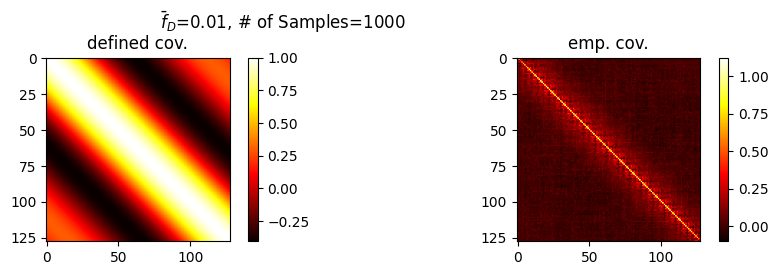

Epoch 4100: KL Div 2.115e-02 G loss -1.337e-02 D loss 1.075e-02:  8

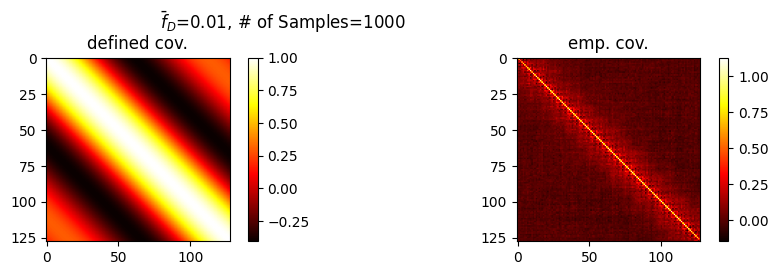

Epoch 4200: KL Div 2.636e-02 G loss -1.467e-02 D loss 1.025e-02:  8

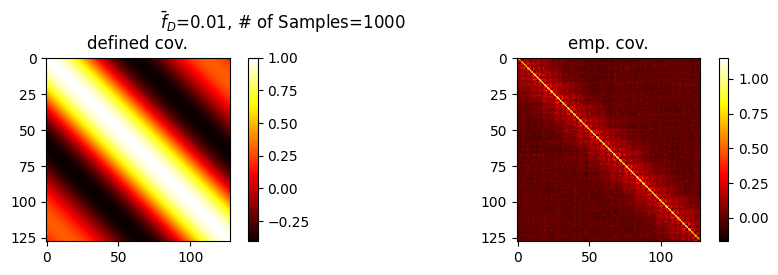

Epoch 4300: KL Div 2.426e-02 G loss -1.478e-02 D loss 1.044e-02:  8

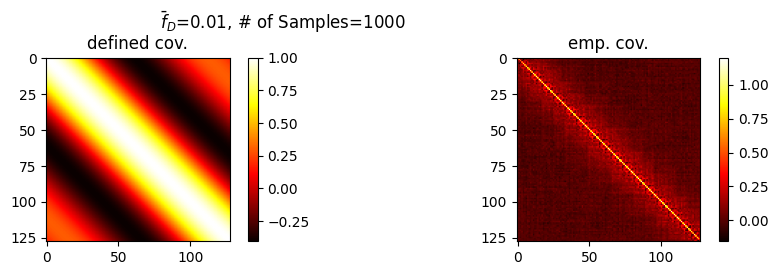

Epoch 4400: KL Div 2.359e-02 G loss -1.357e-02 D loss 1.011e-02:  8

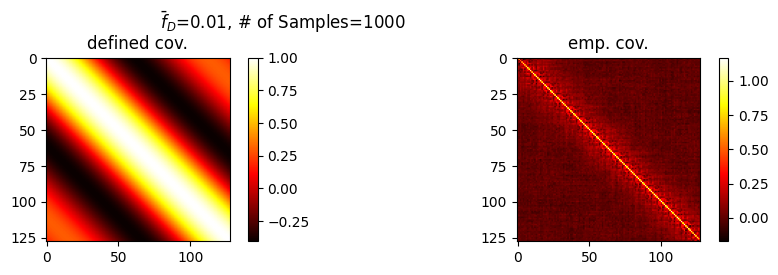

Epoch 4500: KL Div 2.389e-02 G loss -7.500e-03 D loss 1.005e-02:  9

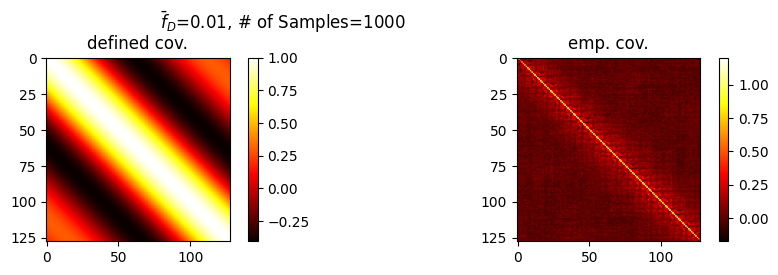

Epoch 4600: KL Div 2.559e-02 G loss -1.282e-02 D loss 9.963e-03:  9

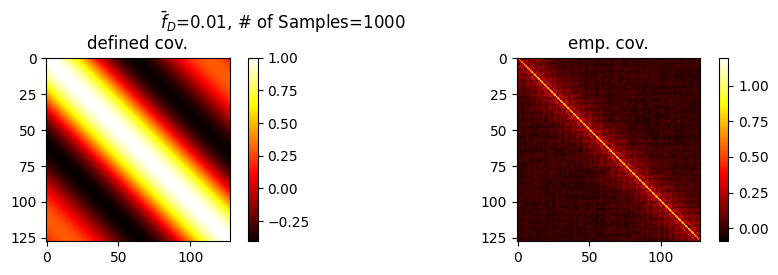

Epoch 4700: KL Div 2.491e-02 G loss -1.113e-02 D loss 9.314e-03:  9

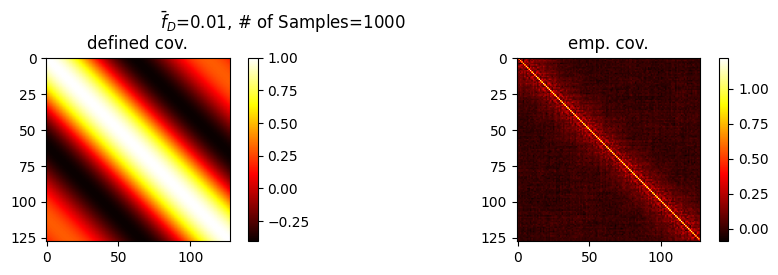

Epoch 4800: KL Div 2.428e-02 G loss -7.636e-03 D loss 9.340e-03:  9

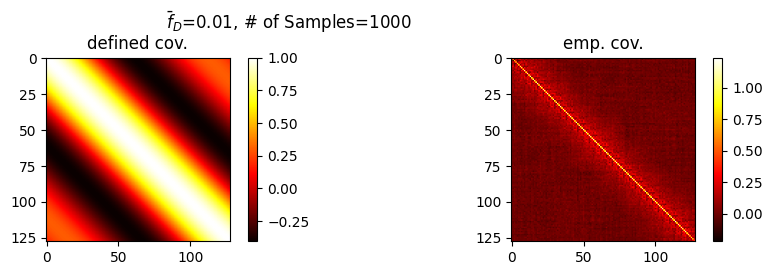

Epoch 4900: KL Div 2.295e-02 G loss -9.016e-03 D loss 9.314e-03:  9

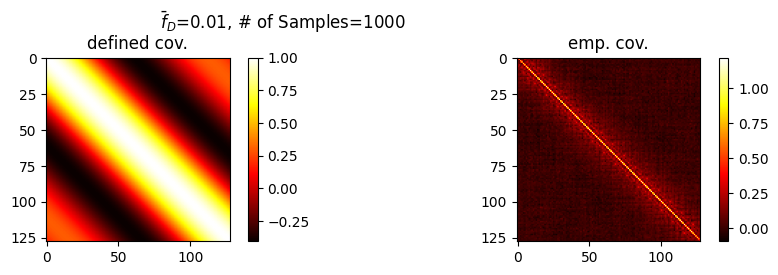

Epoch 4991: KL Div 2.406e-02 G loss -1.065e-02 D loss 9.388e-03: 10

In [ ]:
num_epochs = 5000
save_every = 100
batch_size = 1000
d_lr = 1e-5
g_lr = 1e-5

LOAD = True
milestone = 30
if LOAD:
    G.load_state_dict(torch.load(f'{path}/G-{milestone}.pt', map_location=device))
    D.load_state_dict(torch.load(f'{path}/D-{milestone}.pt', map_location=device))
    step = milestone * save_every 

with tqdm(initial = step, total=num_epochs, ascii=True) as pbar:  
    while step < num_epochs:
        g_loss, d_loss, kl_loss = WGAN.train_WGAN_CNN(G, D, batch_size, n, channel_model, d_lr, g_lr, is_GP=False)
        
        writer_G.add_scalar('train_loss/g_loss', g_loss, step)
        writer_G.add_scalar('train_loss/kl_loss', kl_loss, step)
        writer_D.add_scalar('train_loss/d_loss', d_loss, step)
        
        pbar.set_description(f"Epoch {step+1}: KL Div {kl_loss:.3e} G loss {-g_loss:.3e} D loss {-d_loss:.3e}")

        if (step+1) % 1000 == 0:
            WGAN.plot_GAN(G, 10000, n, channel_model, step)
        if (step+1) % save_every == 0:
            milestone = (step+1) // save_every 
            torch.save(G.state_dict(), f'{path}/G-{milestone}.pt')
            torch.save(D.state_dict(), f'{path}/D-{milestone}.pt')
    
            _ = compare_empirical_cov(G, Config_ch, num_samples = 10 **3, milestone=milestone)
       
        step += 1
        pbar.update(1)
        

## Evaluation: empirical covariance and sliced Wasserstein distance

In [18]:
G.load_state_dict(torch.load(f'{path}/G-{50}.pt', map_location=device))
D.load_state_dict(torch.load(f'{path}/D-{50}.pt', map_location=device))

<All keys matched successfully>

In [22]:
generated_h = compare_empirical_cov(G, Config_ch, num_samples = 10 **5, bs=100, milestone=milestone)

RuntimeError: The expanded size of the tensor (100) must match the existing size (0) at non-singleton dimension 0.  Target sizes: [100, 2, 128].  Tensor sizes: [0, 2, 128]

In [30]:
num_samples = 10**5
bs = 100

# Compute a matrix A such that A*A^H = Cov.
        
# Compute the Cholesky decomposition.
A = torch.linalg.cholesky(Config_ch.cov, upper=False)  # torch.cholesky(Cov, upper=False)
# print(torch.mm(A, A.conj().T))
# print(Cov_h)
A = A[None, :, :].repeat(bs, 1, 1)
h_t = torch.zeros(num_samples, 2*n)

for i in range(num_samples // bs):
    # generate normally distributed matrices
    h = torch.normal(mean=0., std=1., size=(bs, n), dtype=torch.cfloat)
    h = h[:, :, None]
    # Correlated channel matrices h = Ah,  A[n,n] h[n, 1]
    h = torch.bmm(A, h)
    h = h.view(bs, n)
    h_t[bs*i:bs*(i+1),:] = torch.view_as_real(h).view(-1,2*n).contiguous()
    

In [31]:
generated_h_t = torch.view_as_real(generated_h)
generated_h_t = torch.transpose(generated_h_t, 1,2).contiguous().view(-1,2*n).to("cpu") # After taking transpose, it's necessary. 

wasserstein_distance = _sliced_wasserstein(generated_h_t, h_t, 128)
print(wasserstein_distance)

0.471515
